In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pulp import *
from copy import deepcopy
while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.parser import Parser
from src.preprocessing.preprocessor import Preprocessor
from src.solvers.solution import Solution
from src.solvers.greedy import GreedySolver
from src.solvers.pulp_solver import PuLPSolver
from src.solvers.dp import DPSolver
from src.solvers.base_solver import DPMethods
from src.solvers.bb import BBSolver

from time import time
from tqdm import tqdm
from typing import Dict

/tmp/ipykernel_149876/3991191556.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def get_num_triples(dataset : Dict):
    num_triples= 0
    for n in dataset.keys():
        num_triples += len(dataset[n])
    
    return num_triples

## Test 04

In [4]:
parser = Parser("data/testfiles/test4.txt")

In [5]:
t0 = time()
info = parser.read()
t1 = time()

print(f"Total execution time {t1 - t0} s")

0it [00:00, ?it/s]

76804it [00:01, 56912.22it/s]


Total execution time 3.758443832397461 s


In [6]:
dataset : Dict[int, pd.DataFrame ]= info['data']
p, K, M, N = info['p'], info['K'], info['M'], info['N']

In [7]:
preprocessing_results = {}

preprocessing_results['initial data'] = {
    "runtime": 0,
    "num_triples": get_num_triples(dataset)
}
preprocessor = Preprocessor(
    K, 
    M,
    N,
    p,
    dataset
)

t0 = time()

data_1 = preprocessor.remove_trivial_values()
t1 = time()

preprocessing_results['remove trivial values'] = {
    "runtime": (t1 - t0),
    "num_triples": get_num_triples(data_1)
}
t1 = time()

data_2 = preprocessor.remove_ip_dominated(dataset)
t2 = time()
preprocessing_results['remove IP dominated'] = {
    "runtime": t2-t1,
    "num_triples": get_num_triples(data_2)
}
t2 = time()

data_3 = preprocessor.remove_lp_dominated(data_2)
t3 = time()
preprocessing_results['remove LP dominated'] = {
    "runtime": t3-t2,
    "num_triples": get_num_triples(data_3)
}


100%|██████████| 640/640 [00:05<00:00, 110.64it/s]


In [8]:
pd.DataFrame(preprocessing_results)

,initial data,remove trivial values,remove IP dominated,remove LP dominated
runtime,0,15.297902,174.70736,20.033097
num_triples,614400,614400.000000,14688.00000,4974.000000


## Data visualization

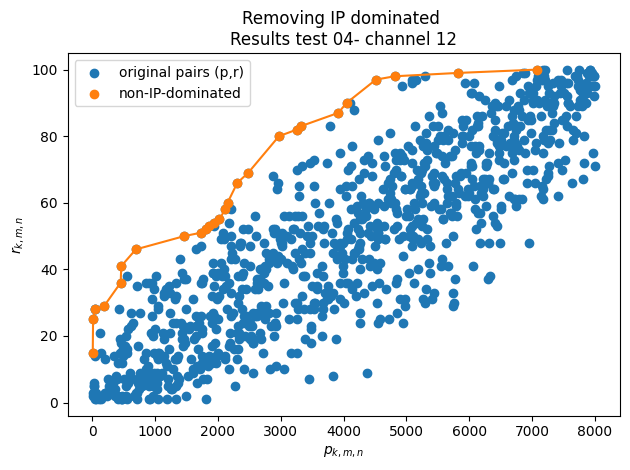

In [30]:
channel_number = 12
plt.scatter(
    data_1[channel_number]['p_k,m,n'],
    data_1[channel_number]['r_k,m,n'],
    label= "original pairs (p,r)"
)

plt.scatter(
    data_2[channel_number]['p_k,m,n'],
    data_2[channel_number]['r_k,m,n'],
    label= "non-IP-dominated"
)

plt.plot(
    data_2[channel_number]['p_k,m,n'],
    data_2[channel_number]['r_k,m,n'],
    color = 'C1'
)


plt.xlabel("$p_{k,m,n}$")
plt.ylabel("$r_{k,m,n}$")
plt.legend()
plt.title(f"Removing IP dominated \nResults test 04- channel {channel_number}")

plt.savefig("img/ip_dominated_test04.png")
plt.tight_layout()

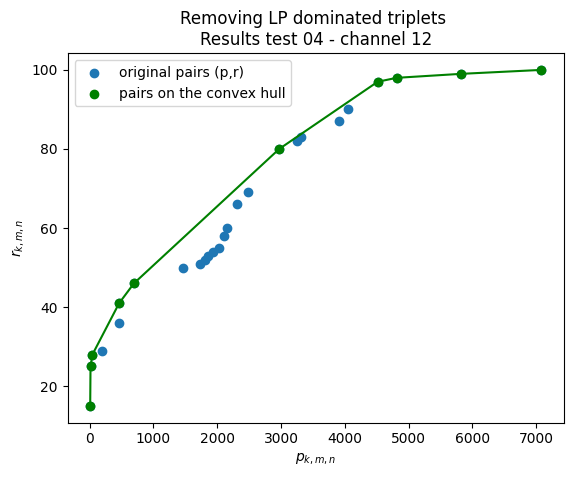

In [22]:
channel_number = 12
plt.scatter(
    data_2[channel_number]['p_k,m,n'],
    data_2[channel_number]['r_k,m,n'],
    label= "original pairs (p,r)"
)

plt.scatter(
    data_3[channel_number]['p_k,m,n'],
    data_3[channel_number]['r_k,m,n'],
    label = "pairs on the convex hull",
    color = "green"
)

plt.plot(
    data_3[channel_number]['p_k,m,n'],
    data_3[channel_number]['r_k,m,n'],
    color = "green"
)

plt.title(f"Removing LP dominated triplets \nResults test 04 - channel {channel_number}")
plt.legend()

plt.xlabel("$p_{k,m,n}$")
plt.ylabel("$r_{k,m,n}$")

plt.savefig("img/lp_dominated_test04.png")

## Greedy algorithm

In [31]:
lp_results = {}

In [33]:
pulp_solver = PuLPSolver(
    K, 
    M,
    N,
    p,
    data_3
)

t1 = time()
pulp_solver.solve()
t2 = time()

lp_results['pulp'] = {
    'runtime': t2-t1,
    'data_rate' : pulp_solver.solution.objective.value()
}

In [34]:
solver = GreedySolver(
    K, 
    M,
    N,
    p,
    data_3
)

t1 = time()
solver.solve(data_3)
t2 = time()

lp_results['greedy'] = {
    'runtime': t2-t1,
    'data_rate' : solver.solution.get_data_rate()
}


In [35]:
pd.DataFrame(lp_results)

,pulp,greedy
runtime,0.112520,1.155703
data_rate,9870.321839,9870.321839


## Solutions to the ILP

In [36]:
ilp_results = {}

In [37]:
dp_solver = DPSolver(
    K, 
    M,
    N,
    p,
    data_3
)

t1 = time()
dp_solver.solve(
    None,
    method = DPMethods.MAXIMIZE_R
)
t2 = time()
ilp_results['DP_maximize_r'] = {
    'runtime' : t2 - t1,
    "data_rate" : dp_solver.solution.get_data_rate()
}

pulp_solver.solve()
U = int(pulp_solver.solution.objective.value())

t1 = time()
dp_solver.solve(
    None,
    method = DPMethods.MINIMIZE_P,
    U = U
)
t2 = time()

ilp_results['DP_minimize_p'] = {
    'runtime' : t2 - t1,
    "data_rate" : dp_solver.solution.get_data_rate()
}

### Branch and Bound

In [38]:
bb_solver = BBSolver(
    K, 
    M,
    N,
    p,
    data_3
)

In [40]:
t1 = time()
bb_solver.solve()
t2 = time()



KeyboardInterrupt: 

In [42]:
ilp_results['Branch&Bound'] = {
    'runtime' : np.inf,
    "data_rate" : np.nan
}

In [43]:
pd.DataFrame(ilp_results)

,DP_maximize_r,DP_minimize_p,Branch&Bound
runtime,81.193411,40.678555,inf
data_rate,9870.000000,9870.000000,NaN
